In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import warnings


from scipy.stats import norm, binom

warnings.filterwarnings('ignore')

# Set up for code 7.25 onwards

In [2]:
# number of plants
N = 100

# initial heights
h0 = norm.rvs(loc=10, scale=2, size=N)

# assign treatment and fungus growth
treatment = np.zeros(N)
treatment[N//2:] = 1

# there is a 10% chance of fungus growth for the plants that have been treated; and 50% for those that haven't
fungus = binom.rvs(n=1, p=0.5 - 0.4 * treatment, loc=0, size=N)

# the mean height for plants without fungus is 10 + 5 = 15; for those with fungus: 10 + 2 = 12
h1 = h0 + norm.rvs(loc=5 - 3 * fungus, scale=1, size=N)

df = pd.DataFrame({'h0': h0, 'h1': h1, 'treatment': treatment, 'fungus': fungus})
df.describe([0.055, 0.945])

,h0,h1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,9.982919,14.405297,0.500000,0.220000
std,1.857343,2.373086,0.502519,0.416333
min,4.876302,7.089627,0.000000,0.000000
5.5%,6.884977,9.940619,0.000000,0.000000
50%,9.975268,14.789469,0.500000,0.000000
94.5%,12.984235,18.070378,1.000000,1.000000
max,14.189077,20.402497,1.000000,1.000000


# Causal Diagram of Fungal Growth Simulation

$$
    H_0 \rightarrow H_1 \leftarrow F \leftarrow T
$$


# Models M6.6, M6.7, M6.8 

### Model M.6.6 

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
     p      & \sim \text{LogNormal}(0, 0.25)
\end{align*}
$$

### Model M6.7

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
    p       & = \alpha + \beta_T \cdot T_i + \beta_F \cdot F_i \\
    \alpha  & \sim \text{LogNormal}(0, 0.25) \\
    \beta_T & \sim N(0, 0.5) \\
    \beta_F & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$


### Model M6.8

$$
\begin{align*}
    h_{1 i} & \sim N(\mu_i, \sigma) \\
    \mu_i   & = h_{0 i} \times p \\
    p       & = \alpha + \beta_T \cdot T_i \\
    \alpha  & \sim \text{LogNormal}(0, 0.25) \\
    \beta_T & \sim N(0, 0.5) \\
    \sigma  & \sim \text{Exponential}(1)
\end{align*}
$$

In [3]:
with pm.Model() as m_6_6:
    p = pm.Lognormal('p', mu=0, sigma=0.25)
    sigma = pm.Exponential('sigma', lam=1)
    
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_6 = pm.sample(2000, tune=2000)
    
with pm.Model() as m_6_7:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    b_F = pm.Normal('b_F', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df['treatment'] + b_F * df['fungus']
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_7 = pm.sample(2000, tune=2000)
    
with pm.Model() as m_6_8:
    a = pm.Lognormal('a', mu=0, sigma=0.25)
    b_T = pm.Normal('b_T', mu=0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1)
    
    p = a + b_T * df['treatment']
    mu = pm.Deterministic('mu', df['h0'].values * p)
    h1 = pm.Normal('h1', mu=mu, sigma=sigma, observed=df['h1'])
    
    trace_6_8 = pm.sample(2000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, p]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 5 seconds.
The acceptance probability does not match the target. It is 0.8872911240063399, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_F, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_T, a]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 9 seconds.


### Code. 7.25

In [4]:
az.waic(trace_6_7, m_6_7, scale='deviance')

Computed from 8000 by 100 log-likelihood matrix

              Estimate       SE
deviance_waic   356.32    11.60
p_waic            3.39        -

### Code 7.26

In [5]:
trace_dict = {'m_6_6': trace_6_6, 
              'm_6_7': trace_6_7, 
              'm_6_8': trace_6_8}

compare_dict = az.compare(trace_dict, ic='waic', scale='deviance')
compare_dict

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_6_7,0,356.322168,3.391886,0.000000,1.000000e+00,11.603663,0.000000,False,deviance
m_6_8,1,425.256170,2.837549,68.934001,1.448841e-14,12.697140,13.201251,False,deviance
m_6_6,2,431.079148,1.863111,74.756979,2.560174e-12,13.084315,14.478343,False,deviance


### Explanation of column names

* p_waic: the WAIC penalty
* d_waic: the difference of each WAIC from best model (the one with lowest WAIC value)
* weight: the relative weight of each model. This can be interpreted as the probability of each model given the data.
* se: the standard error of the WAIC estimates
* dse: the standard error of the difference between the model and the top-ranked model.

## Computing the dse manually

### Code 7.27

In [6]:
waic_6_7 = az.waic(trace_6_7, pointwise=True, scale='deviance')
waic_6_8 = az.waic(trace_6_8, pointwise=True, scale='deviance')

diff = waic_6_7.waic_i - waic_6_8.waic_i
n = len(diff)

dse = np.sqrt(n * np.var(diff)).values
dse

array(13.20125117)

In [7]:
from scipy.stats import norm


# the 99% interval for a standard normal

norm.ppf(q=0.995, loc=0, scale=1)

2.5758293035489004

### Code 7.28

In [8]:
waic_diff = waic_6_8.waic - waic_6_7.waic

waic_diff + np.array([-1, 1]) * dse * 2.6

array([ 34.61074826, 103.25725435])

### Code 7.29

<AxesSubplot:xlabel='Deviance'>

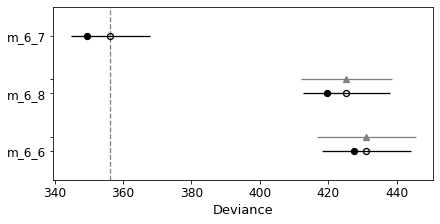

In [9]:
az.plot_compare(compare_dict)

In [10]:
az.summary(trace_6_8, var_names=['a', 'b_T', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.366,0.028,1.315,1.420,0.000,0.000,4042.0,5064.0,1.0
b_T,0.114,0.040,0.037,0.185,0.001,0.000,4151.0,4531.0,1.0
sigma,1.993,0.145,1.730,2.262,0.002,0.001,5023.0,4559.0,1.0


### Code 7.30

In [11]:
waic_6_6 = az.waic(trace_6_6, pointwise=True, scale='deviance')

diff_m6_6_m6_8 = (waic_6_6.waic_i - waic_6_8.waic_i).values

n = len(diff_m6_6_m6_8)
np.sqrt(n * np.var(diff_m6_6_m6_8))

5.636011261818566

### Code 7.31

In [12]:
waic_6_6 = az.waic(trace_6_6, pointwise=True, scale='deviance')
waic_6_7 = az.waic(trace_6_7, pointwise=True, scale='deviance')
waic_6_8 = az.waic(trace_6_8, pointwise=True, scale='deviance')

waic_list = [waic_6_6, waic_6_7, waic_6_8]
dse_matrix = np.zeros((3, 3))

start = 0

while start < len(waic_list):
    for w in range(start, len(waic_list)):
        d = (waic_list[start].waic_i - waic_list[w].waic_i).values
        n = len(d)
        dse_matrix[start, w] = np.sqrt(n * np.var(d))
    start += 1

i_lower = np.tril_indices(3, -1)
dse_matrix[i_lower] = dse_matrix.T[i_lower]

dse_df = pd.DataFrame(dse_matrix, columns=['m_6_6', 'm_6_7', 'm_6_8'], index=['m_6_6', 'm_6_7', 'm_6_8'])

In [13]:
dse_df

,m_6_6,m_6_7,m_6_8
m_6_6,0.000000,14.478343,5.636011
m_6_7,14.478343,0.000000,13.201251
m_6_8,5.636011,13.201251,0.000000


In [14]:
from typing import Dict


def dse_compare(trace_dict: Dict[str, pm.backends.base.MultiTrace]):
    waic_list = []
    columns = []
    
    for model_name, trace in trace_dict.items():
        waic = az.waic(trace, pointwise=True, scale='deviance')
        waic_list.append(waic)
        columns.append(model_name)
        
    num_models = len(columns) 
    dse_matrix = np.zeros((num_models, num_models))

    start = 0

    while start < len(waic_list):
        for w in range(start, len(waic_list)):
            d = (waic_list[start].waic_i - waic_list[w].waic_i).values
            n = len(d)
            dse_matrix[start, w] = np.sqrt(n * np.var(d))
        start += 1

    i_lower = np.tril_indices(num_models, -1)
    dse_matrix[i_lower] = dse_matrix.T[i_lower]

    dse_df = pd.DataFrame(dse_matrix, columns=columns, index=columns)
    return dse_df

In [15]:
dse_compare(trace_dict)

,m_6_6,m_6_7,m_6_8
m_6_6,0.000000,14.478343,5.636011
m_6_7,14.478343,0.000000,13.201251
m_6_8,5.636011,13.201251,0.000000


# Setup for Code 7.32 Onwards

In [16]:
WAFFLE_DATA = 'waffle_divorce.csv'
DATA_FOLDER = '../../data'

df_waf = pd.read_csv(f'{DATA_FOLDER}/{WAFFLE_DATA}')
df_waf['age_stan'] = (df_waf['MedianAgeMarriage'] - df_waf['MedianAgeMarriage'].mean()) / df_waf['MedianAgeMarriage'].std()
df_waf['divorce_stan'] = (df_waf['Divorce'] - df_waf['Divorce'].mean()) / df_waf['Divorce'].std()
df_waf['marriage_stan'] = (df_waf['Marriage'] - df_waf['Marriage'].mean()) /df_waf['Marriage'].std()

In [17]:
with pm.Model() as m_5_1:
    a = pm.Normal('a', mu=0.0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', a + b_A * df_waf['age_stan'])
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=df_waf['divorce_stan'])
    
    trace_5_1 = pm.sample(1000, tune=2000)

    
with pm.Model() as m_5_2:
    a = pm.Normal('a', mu=0.0, sigma=0.2)
    b_M = pm.Normal('b_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', a + b_M * df_waf['marriage_stan'])
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=df_waf['divorce_stan'])
    
    trace_5_2 = pm.sample(1000, tune=2000)

    
with pm.Model() as m_5_3:
    a = pm.Normal('a', mu=0.0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0.0, sigma=0.5)
    b_M = pm.Normal('b_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', a + b_A * df_waf['age_stan'] + b_M * df_waf['marriage_stan'])
    D = pm.Normal('D', mu=mu, sigma=sigma, observed=df_waf['divorce_stan'])
    
    trace_5_3 = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_A, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 8 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, b_A, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 10 seconds.


In [18]:
az.summary(trace_5_1, var_names=['a', 'b_A', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.105,-0.176,0.161,0.001,0.002,4924.0,3083.0,1.0
b_A,-0.565,0.115,-0.753,-0.388,0.002,0.001,4893.0,2986.0,1.0
sigma,0.821,0.088,0.675,0.947,0.001,0.001,4894.0,2849.0,1.0


In [19]:
az.summary(trace_5_2, var_names=['a', 'b_M', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.002,0.114,-0.196,0.172,0.002,0.002,4557.0,2653.0,1.0
b_M,0.350,0.136,0.128,0.559,0.002,0.001,4509.0,3086.0,1.0
sigma,0.949,0.101,0.794,1.106,0.002,0.001,4542.0,2519.0,1.0


In [20]:
az.summary(trace_5_3, var_names=['a', 'b_A', 'b_M', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.102,-0.161,0.167,0.002,0.002,2874.0,2307.0,1.0
b_A,-0.617,0.157,-0.873,-0.374,0.003,0.002,2793.0,2670.0,1.0
b_M,-0.067,0.157,-0.316,0.181,0.003,0.002,2647.0,2806.0,1.0
sigma,0.824,0.086,0.685,0.954,0.002,0.001,2791.0,2167.0,1.0


### Code 7.33

In [21]:
# LOO is leave-one-out (PSIS-LOO loo) cross-validation

az.compare({'m_5_1': trace_5_1, 'm_5_2': trace_5_2, 'm_5_3': trace_5_3}, ic='loo', scale='deviance')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,126.370926,3.950891,0.000000,8.920749e-01,12.968338,0.000000,False,deviance
m_5_3,1,128.060847,5.037874,1.689921,3.330669e-16,13.112544,0.748621,False,deviance
m_5_2,2,139.630539,3.127238,13.259613,1.079251e-01,9.913697,9.428357,False,deviance


In [22]:

az.compare({'m_5_1': trace_5_1, 'm_5_2': trace_5_2, 'm_5_3': trace_5_3}, ic='waic', scale='deviance')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_5_1,0,126.149772,3.840314,0.000000,8.941000e-01,12.808347,0.000000,True,deviance
m_5_3,1,127.695391,4.855147,1.545619,1.225215e-15,12.882760,0.751677,True,deviance
m_5_2,2,139.577985,3.100961,13.428214,1.059000e-01,9.889408,9.256755,True,deviance


### Code 7.34

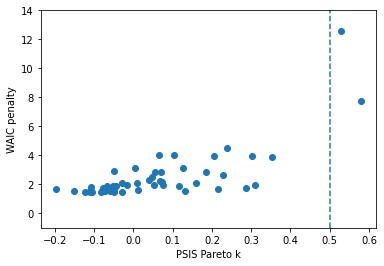

In [23]:
psis_m_5_3 = az.loo(trace_5_3, pointwise=True, scale='deviance')
waic_m_5_3 = az.waic(trace_5_3, pointwise=True, scale='deviance')

plt.scatter(psis_m_5_3.pareto_k, waic_m_5_3.waic_i)
plt.xlabel('PSIS Pareto k')
plt.ylabel('WAIC penalty')

plt.ylim(-1, 14)
plt.vlines(x=0.5, ymin=-1, ymax=14, linestyle='--')

## Using Student-$t$ Instead of the Normal for Divorce Rates

Recall that if $Z \sim N(0, 1)$ and $Y \sim \chi_{m}^2$ are independent random variables, then 
$$
    X = \frac{Z}{\sqrt{Y / m}} 
$$
has the Student-$t$ distribution with $m$ degrees of freedom. The pdf of this distribution is:
$$
    f_{X}(x) = \frac{\Gamma(\frac{m + 1}{2})}{\Gamma(\frac{m}{2})} \cdot 
               \frac{1}{\sqrt{\pi m}} \cdot 
               \left ( 1 + \frac{x^2}{m} \right )^{- (m + 1) / 2}.
$$

The usual context in which this distribution arises is when we have a random sample $X_1, \ldots, X_n$ from a normal distribution $N(\mu, \sigma^2)$. Then the sample mean $\bar{X}_n \sim N(\mu, \sigma^2 / n)$ and the normalized sample mean has the standard normal distribution:
$$
    \frac{\bar{X}_n - \mu}{\sigma / \sqrt{n}} \sim N(0, 1).
$$

It turns out that the scaled sample variance has the chi-squared distirbution with $n - 1$ degrees of freedom. 
$$
    \frac{\sum_{i = 1}^n (X_i - \bar{X}_n)^2}{\sigma^2} \sim \chi^2_{n - 1}.
$$

And importantly, for random samples from a normal distribution, the sample mean and sample variance are independent random variables. Thus, 
$$
     \frac{\bar{X}_n - \mu}{\sigma / \sqrt{n}} \div 
     \sqrt{\frac{\sum_{i = 1}^n (X_i - \bar{X}_n)^2}{\sigma^2 (n -1)}} \sim t_{n - 1}.
$$

This is usually written as:
$$
     \frac{\bar{X}_n - \mu}{\sigma' / \sqrt{n}} \sim t_{n - 1},
$$
where 
$$
    \sigma' = \sqrt{\frac{\sum_{i = 1}^n (X_i - \bar{X}_n)^2}{n - 1}}.
$$

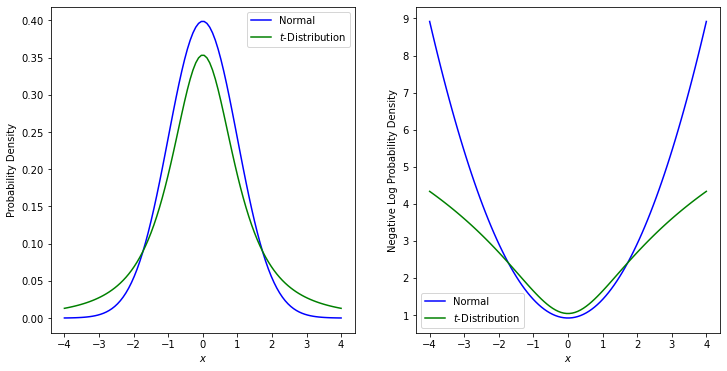

In [24]:
from scipy.stats import norm, t


x_vals = np.linspace(start=-4, stop=4, num=100)
y_norm = norm(loc=0, scale=1)
y_t = t(df=2, loc=0, scale=1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.plot(x_vals, y_norm.pdf(x_vals), 'b', label='Normal')
ax1.plot(x_vals, y_t.pdf(x_vals), 'g', label=r'$t$-Distribution')

ax1.set_xlabel(r'$x$')
ax1.set_ylabel('Probability Density')

ax1.legend()

ax2.plot(x_vals, -y_norm.logpdf(x_vals), 'b', label='Normal')
ax2.plot(x_vals, -y_t.logpdf(x_vals), 'g', label=r'$t$-Distribution')

ax2.set_xlabel(r'$x$')
ax2.set_ylabel('Negative Log Probability Density')

ax2.legend()

plt.show()

### Code 7.35

In [25]:
with pm.Model() as m_5_3t:
    a = pm.Normal('a', mu=0.0, sigma=0.2)
    b_A = pm.Normal('b_A', mu=0.0, sigma=0.5)
    b_M = pm.Normal('b_M', mu=0.0, sigma=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    mu = pm.Deterministic('mu', a + b_A * df_waf['age_stan'] + b_M * df_waf['marriage_stan'])
    D = pm.StudentT('D', nu=2, mu=mu, sigma=sigma, observed=df_waf['divorce_stan'])
    
    trace_5_3t = pm.sample(1000, tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_M, b_A, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 9 seconds.


In [26]:
az.summary(trace_5_3t, var_names=['a', 'b_A', 'b_M', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.023,0.104,-0.144,0.187,0.002,0.002,3775.0,2452.0,1.0
b_A,-0.691,0.148,-0.931,-0.465,0.003,0.002,3022.0,2943.0,1.0
b_M,0.055,0.210,-0.266,0.395,0.004,0.003,2710.0,2722.0,1.0
sigma,0.579,0.087,0.436,0.706,0.001,0.001,3939.0,2968.0,1.0


In [27]:
az.summary(trace_5_3, var_names=['a', 'b_A', 'b_M', 'sigma'], hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.102,-0.161,0.167,0.002,0.002,2874.0,2307.0,1.0
b_A,-0.617,0.157,-0.873,-0.374,0.003,0.002,2793.0,2670.0,1.0
b_M,-0.067,0.157,-0.316,0.181,0.003,0.002,2647.0,2806.0,1.0
sigma,0.824,0.086,0.685,0.954,0.002,0.001,2791.0,2167.0,1.0


## Discussion

The estimate of $b_A$ for model $m_{5.3t}$ is more negative. This suggests a stronger influence of `median age at marriage` on the `divorce rate`. This is accounted for by the fact that a state like Idaho which has a low median age of marriage and a low divorce rate was an influential observation in model $m_{5.3}$. Its effect in model $m_{5.3}$ was to diminish the association of `age` and `divorce rate`. Using a $t$-distribution reduces this influence and in model $m_{5.3t}$, the association between `age` and `divorce rate` is higher. However, whether a coefficient estimate increases or decreases as a result of using a fatter-tailed distribution will depend on the exact problem at hand. 

In [28]:
# LOO is leave-one-out (PSIS-LOO loo) cross-validation

az.compare({'m_5_1': trace_5_1, 'm_5_2': trace_5_2, 'm_5_3t': trace_5_3t}, ic='loo', scale='deviance')

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_5_1,0,126.370926,3.950891,0.000000,8.920402e-01,12.968338,0.000000,False,deviance
m_5_3t,1,133.289235,6.453039,6.918309,1.386030e-14,11.465952,6.086030,False,deviance
m_5_2,2,139.630539,3.127238,13.259613,1.079598e-01,9.913697,9.428357,False,deviance
